# ⚙️ Notebook 02 — Preprocessing & Feature Engineering  

In this notebook, I prepare the dataset for modeling by applying:

### **1. Data cleaning**
- Verifying types  
- Handling categorical features  
- Detecting potential outliers  

### **2. Preprocessing**
- Standardization of numeric features  
- One-hot encoding for categorical variables  
- Train/test split with stratification  

### **3. Feature Engineering**
Based on Notebook 01 insights, I create new model-ready variables:

- **Readiness_Strength**  
  (knee strength + hamstring flexibility + balance)

- **Workload_Index**  
  (training hours + matches played)

- **Prep_Score**  
  (warmup adherence + nutrition quality)

- **Injury_History_Weight**  
  (previous injuries × 1.5)

- Additional domain-inspired metrics as needed

The final output is a structured dataset ready for modeling in Notebook 03.


In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder

plt.style.use("seaborn-v0_8")

df = pd.read_csv("../data/data.csv")
df.head()


,Age,Height_cm,Weight_kg,Position,Training_Hours_Per_Week,Matches_Played_Past_Season,Previous_Injury_Count,Knee_Strength_Score,Hamstring_Flexibility,Reaction_Time_ms,Balance_Test_Score,Sprint_Speed_10m_s,Agility_Score,Sleep_Hours_Per_Night,Stress_Level_Score,Nutrition_Quality_Score,Warmup_Routine_Adherence,Injury_Next_Season,BMI
0,22,173,64,Midfielder,11.575308,36,1,77.460279,79.115738,284.487853,91.212476,5.874630,77.599705,8.238293,46.616415,81.472206,1,0,21.383942
1,18,170,67,Midfielder,12.275869,37,2,72.634442,82.541688,250.579249,87.294078,5.796269,94.418987,8.983737,49.368037,81.056677,1,0,23.183391
2,22,186,75,Forward,12.254896,12,2,77.064490,75.943631,269.119918,83.440688,5.731209,70.179176,7.229193,43.132808,64.877457,0,1,21.678807
3,20,172,62,Defender,9.006678,11,1,82.810232,73.878324,226.376412,87.591894,6.220212,83.473824,7.681029,51.528529,89.824744,1,0,20.957274
4,18,172,94,Midfielder,12.683668,10,2,76.772859,76.653043,229.021042,83.125161,5.385958,87.037256,6.728091,52.379718,71.569197,0,1,31.773932


## 1. Basic Type Review

We confirm numeric vs categorical features and inspect `Position`.


In [2]:
df.dtypes


Age                             int64
Height_cm                       int64
Weight_kg                       int64
Position                       object
Training_Hours_Per_Week       float64
Matches_Played_Past_Season      int64
Previous_Injury_Count           int64
Knee_Strength_Score           float64
Hamstring_Flexibility         float64
Reaction_Time_ms              float64
Balance_Test_Score            float64
Sprint_Speed_10m_s            float64
Agility_Score                 float64
Sleep_Hours_Per_Night         float64
Stress_Level_Score            float64
Nutrition_Quality_Score       float64
Warmup_Routine_Adherence        int64
Injury_Next_Season              int64
BMI                           float64
dtype: object

In [3]:
df["Position"].value_counts()

Position
Midfielder    213
Defender      204
Forward       197
Goalkeeper    186
Name: count, dtype: int64

## 2. Create working copy for feature engineering

Make a copy to manipulate and keep the original dataframe intact.


In [4]:
df_fe = df.copy()
df_fe.head()


,Age,Height_cm,Weight_kg,Position,Training_Hours_Per_Week,Matches_Played_Past_Season,Previous_Injury_Count,Knee_Strength_Score,Hamstring_Flexibility,Reaction_Time_ms,Balance_Test_Score,Sprint_Speed_10m_s,Agility_Score,Sleep_Hours_Per_Night,Stress_Level_Score,Nutrition_Quality_Score,Warmup_Routine_Adherence,Injury_Next_Season,BMI
0,22,173,64,Midfielder,11.575308,36,1,77.460279,79.115738,284.487853,91.212476,5.874630,77.599705,8.238293,46.616415,81.472206,1,0,21.383942
1,18,170,67,Midfielder,12.275869,37,2,72.634442,82.541688,250.579249,87.294078,5.796269,94.418987,8.983737,49.368037,81.056677,1,0,23.183391
2,22,186,75,Forward,12.254896,12,2,77.064490,75.943631,269.119918,83.440688,5.731209,70.179176,7.229193,43.132808,64.877457,0,1,21.678807
3,20,172,62,Defender,9.006678,11,1,82.810232,73.878324,226.376412,87.591894,6.220212,83.473824,7.681029,51.528529,89.824744,1,0,20.957274
4,18,172,94,Midfielder,12.683668,10,2,76.772859,76.653043,229.021042,83.125161,5.385958,87.037256,6.728091,52.379718,71.569197,0,1,31.773932


## 3. Feature Engineering (rationale)

Based on Notebook 01 correlations and sports science reasoning, we create:

- Readiness_Strength = Knee_Strength_Score + Hamstring_Flexibility + Balance_Test_Score  
- Workload_Index = Training_Hours_Per_Week + Matches_Played_Past_Season  
- Prep_Score = Warmup_Routine_Adherence + Nutrition_Quality_Score  
- Injury_History_Weight = Previous_Injury_Count * 1.5

These features combine related signals into interpretable indices.


In [5]:
df_fe["Readiness_Strength"] = (
    df_fe["Knee_Strength_Score"] 
    + df_fe["Hamstring_Flexibility"] 
    + df_fe["Balance_Test_Score"]
)

df_fe["Workload_Index"] = (
    df_fe["Training_Hours_Per_Week"] 
    + df_fe["Matches_Played_Past_Season"]
)

df_fe["Prep_Score"] = (
    df_fe["Warmup_Routine_Adherence"] 
    + df_fe["Nutrition_Quality_Score"]
)

df_fe["Injury_History_Weight"] = df_fe["Previous_Injury_Count"] * 1.5

df_fe[["Readiness_Strength", "Workload_Index", "Prep_Score", "Injury_History_Weight"]].head()


,Readiness_Strength,Workload_Index,Prep_Score,Injury_History_Weight
0,247.788493,47.575308,82.472206,1.5
1,242.470208,49.275869,82.056677,3.0
2,236.448809,24.254896,64.877457,3.0
3,244.280450,20.006678,90.824744,1.5
4,236.551063,22.683668,71.569197,3.0


## 4. Check engineered features — distributions & correlation with target

We visualize distributions and compute correlation of the engineered features with the target to justify their use.



,Readiness_Strength,Workload_Index,Prep_Score,Injury_History_Weight,Injury_Next_Season
Readiness_Strength,1.000000,0.072574,0.263994,-0.285528,-0.679833
Workload_Index,0.072574,1.000000,0.032802,0.046147,-0.034262
Prep_Score,0.263994,0.032802,1.000000,-0.099712,-0.423471
Injury_History_Weight,-0.285528,0.046147,-0.099712,1.000000,0.382226
Injury_Next_Season,-0.679833,-0.034262,-0.423471,0.382226,1.000000


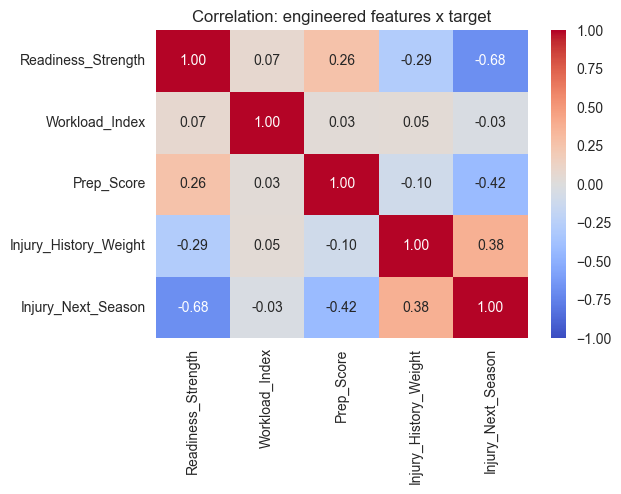

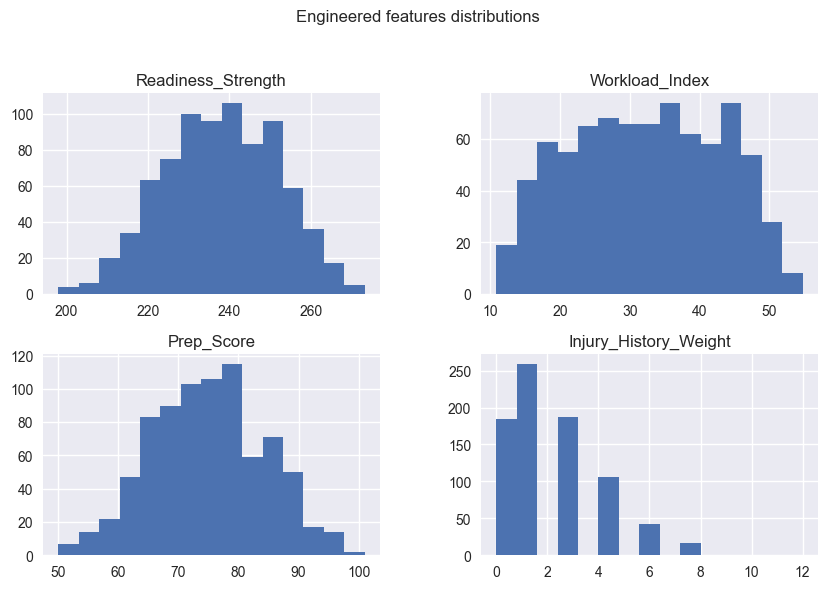

In [6]:
# === Verificação das features engenheirizadas ===
fe_cols = ["Readiness_Strength", "Workload_Index", "Prep_Score", "Injury_History_Weight", "Injury_Next_Season"]

# correlação simples
corr_fe = df_fe[fe_cols].corr()
display(corr_fe)

# heatmap só das engineered features vs target
plt.figure(figsize=(6,4))
sns.heatmap(corr_fe, annot=True, fmt=".2f", cmap="coolwarm", vmin=-1, vmax=1)
plt.title("Correlation: engineered features x target")
plt.show()

# histogramas (distribuições)
df_fe[fe_cols[:-1]].hist(figsize=(10,6), bins=15)
plt.suptitle("Engineered features distributions", y=1.02)
plt.show()



### Notes

If distributions show extreme skew or outliers, we will consider winsorization or log transforms later.
At this stage, we keep the raw engineered features and standardize them in the preprocessing pipeline.


## 5. Train/Test Split (safe)

We perform a stratified train/test split here to preserve target balance.
**Important:** we DO NOT fit or transform scalers/encoders here to avoid leakage.
The `preprocessor` object will be fit inside Notebook 03 during model training.


In [7]:
# separate X / y
X = df_fe.drop("Injury_Next_Season", axis=1)
y = df_fe["Injury_Next_Season"]

# feature type lists (useful for pipeline)
numeric_features = X.select_dtypes(include=[np.number]).columns.tolist()
categorical_features = X.select_dtypes(exclude=[np.number]).columns.tolist()

# stratified split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=42, stratify=y
)

print("Shapes:")
print("X_train:", X_train.shape)
print("X_test :", X_test.shape)
print("y_train:", y_train.shape)
print("y_test :", y_test.shape)

print("\nNumber of numeric features:", len(numeric_features))
print("Categorical features:", categorical_features)


Shapes:
X_train: (600, 22)
X_test : (200, 22)
y_train: (600,)
y_test : (200,)

Number of numeric features: 21
Categorical features: ['Position']


## 6. Preprocessing Pipeline (object only)

We build a ColumnTransformer combining:
- StandardScaler for numeric columns
- OneHotEncoder for categorical columns (Position)
We save the PREPROCESSOR object (config) but DO NOT fit it here.


In [8]:
import joblib
import os

# build preprocessor object
preprocessor = ColumnTransformer(
    transformers=[
        ("num", StandardScaler(), numeric_features),
        ("cat", OneHotEncoder(drop="first", sparse_output=False), categorical_features),
    ],
    remainder="drop"
)


# Save only the preprocessor object (no fit)
os.makedirs("../artifacts", exist_ok=True)
joblib.dump(preprocessor, "../artifacts/preprocessor.pkl")
print("Saved preprocessor to ../artifacts/preprocessor.pkl")


Saved preprocessor to ../artifacts/preprocessor.pkl


### Why we do not fit-transform here

Fitting scalers / encoders must be done only on TRAIN data inside the modeling step.  
If we fit here, there's a risk of **data leakage** (information from test set entering preprocessing).  
In Notebook 03 the pipeline will be fit on X_train and applied to X_test correctly (fit_transform on train, transform on test).


## 7. Save feature lists (optional)

We store the list of numeric and categorical feature names to ensure Notebook 03 uses the exact same order.


In [9]:
joblib.dump(numeric_features, "../artifacts/numeric_features.pkl")
joblib.dump(categorical_features, "../artifacts/categorical_features.pkl")
print("Saved numeric and categorical feature lists.")



Saved numeric and categorical feature lists.


## Done — Checklist

- [x] Engineered features created and inspected  
- [x] Train/test split created (stratified)  
- [x] Preprocessor object created and saved (no fit)  
- [x] Feature lists saved for modeling  

Next: open **Notebook 03 — Model Training**, load `preprocessor.pkl`, `numeric_features.pkl`, `categorical_features.pkl`, and apply the pipeline properly (fit on train, transform test) inside a Pipeline with the models.
